In [ ]:
!pip install emoji

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=d88b9bd7368ade8d43f3231ba1a0dfbc8a258e33d5ea6d21d52dbcf98c386f31
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import emoji
import nltk
from nltk.corpus import stopwords 
import string
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

nltk.download('stopwords')  
stop_words = set(stopwords.words('english')) 

#Reading datasets from csv and tsv files

olid_train_dataset = pd.read_csv('/content/drive/My Drive/OLIDv1.0/olid-training-v1.0.tsv',sep='\t',index_col=0)
olid_test_dataset_a = pd.read_csv('/content/drive/My Drive/OLIDv1.0/testset-levela.tsv',sep='\t',index_col=0)

olid_test_labels_a = pd.read_csv('/content/drive/My Drive/OLIDv1.0/labels-levela.csv',names=['label'],index_col=0)
olid_test_labels_b = pd.read_csv('/content/drive/My Drive/OLIDv1.0/labels-levelb.csv',names=['label'],index_col=0)
olid_test_labels_c = pd.read_csv('/content/drive/My Drive/OLIDv1.0/labels-levelc.csv',names=['label'],index_col=0)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Create lists for train and test subtask labels
train_data_subtask_a = list(olid_train_dataset['tweet'][:])
test_data_subtask_a = list(olid_test_dataset_a['tweet'][:])

train_labels_subtask_a = list(olid_train_dataset['subtask_a'][:])
train_labels_subtask_b = list(olid_train_dataset['subtask_b'][:])
train_labels_subtask_c = list(olid_train_dataset['subtask_c'][:])

a_indexes = list(olid_test_labels_a.index)

test_labels_subtask_a = list(olid_test_labels_a['label'])
test_labels_subtask_b = []
test_labels_subtask_c = []

for i in range(len(a_indexes)):
  if a_indexes[i] in olid_test_labels_b.index:
    test_labels_subtask_b.append(olid_test_labels_b.loc[a_indexes[i]]['label'])
  else:
    test_labels_subtask_b.append('nan')

  if a_indexes[i] in olid_test_labels_c.index:
    test_labels_subtask_c.append(olid_test_labels_c.loc[a_indexes[i]]['label'])
  else:
    test_labels_subtask_c.append('nan')

In [ ]:
#Combine classes for both test and train dataset
def concatenate_five_classes(labels_a,labels_b,labels_c):
  combined_class = []
  for i in range(len(labels_a)):
    if str(labels_b[i]) == 'nan' and str(labels_c[i]) == 'nan':
      combined_class.append('NOT')
    elif str(labels_b[i]) != 'nan' and str(labels_c[i]) == 'nan':
      combined_class.append('OFF-UNT')
    else:
      combined_class.append('OFF-TIN-'+str(labels_c[i]))
    
  return combined_class

train_labels_abc = concatenate_five_classes(train_labels_subtask_a,train_labels_subtask_b,train_labels_subtask_c)
test_labels_abc = concatenate_five_classes(test_labels_subtask_a,test_labels_subtask_b,test_labels_subtask_c)

In [ ]:
len(test_labels_abc)

860

In [ ]:
#Sub Task A - Binary Classification for text being offensive and not offensive
#Tokenization and Preprocessing for train and test data

from nltk.tokenize import WhitespaceTokenizer

whitespacetokenizer = WhitespaceTokenizer()

#Tokenization
subtask_a_corpus = [whitespacetokenizer.tokenize(emoji.demojize(i)) for i in train_data_subtask_a]
subtask_a_corpus_test = [whitespacetokenizer.tokenize(emoji.demojize(i)) for i in test_data_subtask_a]

def preprocess_corpus(corpus,corpus_labels,corpus_labels_abc):
  corpus_pre_processed = []
  corpus_pre_processed_labels = []
  corpus_pre_processed_labels_abc = []

  #Strip words of punctuations and digits
  
  punctuationList = string.punctuation.replace("*","") #To ignore * 
  punctuationList = punctuationList.replace(":","")  #To ignore : in emoji strings
  punctuationList = punctuationList + '’'

  table = str.maketrans('', '', punctuationList+'0123456789')

  corpus_stripped = []
  for words in corpus:
    stripped = []
    for w in words:
      stripped.append(w.translate(table))
    corpus_stripped.append(stripped) 

  for sentence_index in range(len(corpus_stripped)):
    new_sentence = []
    for word in corpus_stripped[sentence_index]:
      word = word.lower()
      if word.isdigit() or word == ''  or word == 'url' or word == 'user' or word == 'maga'  or word in stop_words:
        pass
      else:
        new_sentence.append(word)
    

    corpus_pre_processed.append(new_sentence)

    #Create new list of labels with corresponding preprocessed corpus data
    corpus_pre_processed_labels.append(corpus_labels[sentence_index])
    corpus_pre_processed_labels_abc.append(corpus_labels_abc[sentence_index])

  return corpus_pre_processed,corpus_pre_processed_labels,corpus_pre_processed_labels_abc



In [ ]:
preprocessed_corpus_a,preprocessed_corpus_a_labels,preprocessed_corpus_labels_abc = preprocess_corpus(subtask_a_corpus,train_labels_subtask_a,train_labels_abc)
preprocessed_corpus_a_test,preprocessed_corpus_a_labels_test,preprocessed_corpus_labels_abc_test = preprocess_corpus(subtask_a_corpus_test,test_labels_subtask_a,test_labels_abc)

In [ ]:
flat_corpus_a = []
for sentence_index in range(len(preprocessed_corpus_a)):
  for word in preprocessed_corpus_a[sentence_index]:
    flat_corpus_a.append(word)


In [ ]:
#List of unique words / Vocabulary
corpus_a_word_index = set(flat_corpus_a)

#Word to indices dictionary with first 3 indexes for extra tokens
word2idx = {word:id+3 for id,word in enumerate(corpus_a_word_index)}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2  

idx2word = {id:word for (word,id) in word2idx.items()}


In [ ]:
#Preparing training and test data and labels before feeding to model
X_train = []
y_train = []

for i in range(len(preprocessed_corpus_a)):
    X_train.append([word2idx[j] for j in preprocessed_corpus_a[i]])
    
    if preprocessed_corpus_a_labels[i] == 'OFF':
      y_train.append(1)
    else:
      y_train.append(0)

X_test = []
y_test = []

#Assigning index value of <UNK> -> 2 to words in test data that are not in word2idx dictionary
for i in range(len(preprocessed_corpus_a_test)):
    X_test.append([word2idx[j] if j in word2idx.keys() else word2idx['<UNK>'] for j in preprocessed_corpus_a_test[i]])
    
    if preprocessed_corpus_a_labels_test[i] == 'OFF':
      y_test.append(1)
    else:
      y_test.append(0)


In [ ]:
#Predefined functions for one hot and global average pooling in Lab 4

import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding,LSTM,Dropout,SimpleRNN,Conv1D,GlobalMaxPooling1D
from keras import backend as K
from keras.models import Sequential

def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))
    
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

Using TensorFlow backend.


In [ ]:
VOCAB_SIZE = len(corpus_a_word_index)+2
MAX_SEQUENCE_LENGTH = 60

X_train_enc = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word2idx["<PAD>"],
                                                        padding='pre',
                                                        maxlen=MAX_SEQUENCE_LENGTH)
X_test_enc =  keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word2idx["<PAD>"],
                                                        padding='pre',
                                                        maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
#Model1
model = keras.Sequential()
model.add(Lambda(OneHot(input_dim=VOCAB_SIZE,input_length=MAX_SEQUENCE_LENGTH)))
model.add(GlobalAveragePooling1DMasked())
model.add(Dense(units=128))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
#Model 2
EMBED_SIZE = 100
model2 = keras.Sequential()
model2.add(Embedding(input_dim=VOCAB_SIZE,output_dim=EMBED_SIZE))
#model2.add(Dropout(rate=0.5))
model2.add(LSTM(units=100,activation='relu'))
#model2.add(Dropout(rate=0.5))
model2.add(Dense(units=1,activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2188200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,268,701
Trainable params: 2,268,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Model 3
EMBED_SIZE = 100
model3 = keras.Sequential()
model3.add(Embedding(input_dim=VOCAB_SIZE,output_dim=EMBED_SIZE))
model3.add(Dropout(rate=0.5))
model3.add(Conv1D(filters=250,kernel_size=3,strides=1,padding='valid',kernel_initializer='glorot_uniform'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(rate=0.5))
model3.add(Dense(units=1,activation='sigmoid'))
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
X_val = np.array(X_train_enc[:3000])
partial_X_train = np.array(X_train_enc[3000:])

y_val = np.array(y_train[:3000])
partial_y_train = np.array(y_train[3000:])

In [ ]:
history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=3,
                    batch_size=100,
                    validation_data=(X_val, y_val),
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10240 samples, validate on 3000 samples
Epoch 1/3
10240/10240 [==============================] - 14s 1ms/step - loss: 0.6293 - accuracy: 0.6687 - val_loss: 0.6087 - val_accuracy: 0.6577
Epoch 2/3
10240/10240 [==============================] - 12s 1ms/step - loss: 0.5250 - accuracy: 0.7741 - val_loss: 0.5636 - val_accuracy: 0.7537
Epoch 3/3
10240/10240 [==============================] - 12s 1ms/step - loss: 0.6756 - accuracy: 0.8404 - val_loss: 0.5489 - val_accuracy: 0.7467


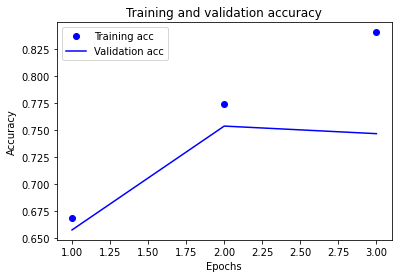

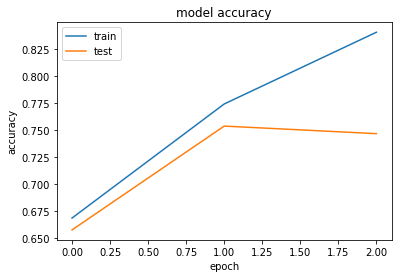

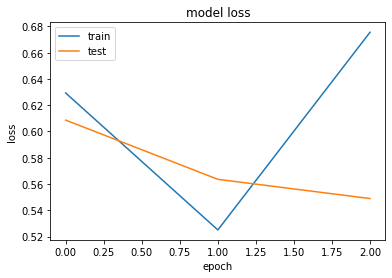

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')

#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [ ]:
results = model2.evaluate(X_test_enc,y_test)
print(f'Test loss - {results[0]} Test accuracy - {results[1]}')

860/860 [==============================] - 0s 318us/step
Test loss - 0.4807213320288547 Test accuracy - 0.804651141166687


In [ ]:
#Sub Task ABC
#For 2nd task, create combined class for each row out of 5 classes

encoded_label = LabelEncoder().fit_transform(preprocessed_corpus_labels_abc)
encoded_label = encoded_label.reshape((len(encoded_label),1))
encoded_onehot_abc = np.array(OneHotEncoder(sparse=False).fit_transform(encoded_label))

encoded_label_test = LabelEncoder().fit_transform(preprocessed_corpus_labels_abc_test)
encoded_label_test = encoded_label_test.reshape((len(encoded_label_test),1))
encoded_onehot_abc_test = np.array(OneHotEncoder(sparse=False).fit_transform(encoded_label_test))

In [ ]:
#Model 4
EMBED_SIZE = 200
model4 = keras.Sequential()
model4.add(Embedding(input_dim=VOCAB_SIZE,output_dim=EMBED_SIZE))
model4.add(Dropout(rate=0.5))
model4.add(LSTM(units=100,activation='relu'))
model4.add(Dropout(rate=0.5))
model4.add(Dense(units=5,activation='softmax'))
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         4376400   
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 4,497,305
Trainable params: 4,497,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Model 5
EMBED_SIZE = 200
model5 = keras.Sequential()
model5.add(Embedding(input_dim=VOCAB_SIZE,output_dim=EMBED_SIZE))
model5.add(Dropout(rate=0.5))
model5.add(Conv1D(filters=50,kernel_size=3,strides=1,padding='SAME',kernel_initializer='glorot_uniform'))
model5.add(GlobalMaxPooling1D())
model5.add(Dense(100))
model5.add(Dropout(rate=0.5))
model5.add(Dense(units=5,activation='softmax'))
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         4376400   
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 50)          30050     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [ ]:
y_val_abc = np.array(encoded_onehot_abc[:3000])
partial_y_train_abc = np.array(encoded_onehot_abc[3000:])



In [ ]:
history2 = model5.fit(partial_X_train,
                    partial_y_train_abc,
                    epochs=3,
                    batch_size=100,
                    validation_data=(X_val, y_val_abc),
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10240 samples, validate on 3000 samples
Epoch 1/3
10240/10240 [==============================] - 6s 569us/step - loss: 1.0608 - accuracy: 0.6639 - val_loss: 1.0513 - val_accuracy: 0.6577
Epoch 2/3
10240/10240 [==============================] - 1s 102us/step - loss: 0.9081 - accuracy: 0.6948 - val_loss: 0.8714 - val_accuracy: 0.7103
Epoch 3/3
10240/10240 [==============================] - 1s 104us/step - loss: 0.7060 - accuracy: 0.7573 - val_loss: 0.8721 - val_accuracy: 0.7063


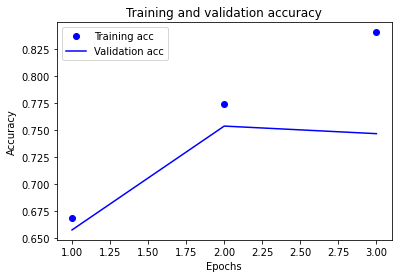

In [ ]:
history_dict = history2.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model5.evaluate(X_test_enc,encoded_onehot_abc_test)
print(f'Test loss - {results[0]} Test accuracy - {results[1]}')

860/860 [==============================] - 0s 106us/step
Test loss - 0.7924199187478354 Test accuracy - 0.7639535069465637
